## Blackjack with Reinforcement Learning Algorithms

Comparing different monte carlo on-policy and off-policy methods with a q learning method and with the supposed optimal policies

In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rl_methods import *

# %load_ext autoreload
# %autoreload 2
!python tests_rl_methods.py




In [2]:
env = gym.make('Blackjack-v0', natural=True)

## Define commonly used functions for policies

In [3]:
# initialize a dataframe holding q values for each state and action

def initialize_q(initial_val = 0):
    q = pd.DataFrame()
    idx = 0
    for m in range(4, 31):
        for d in range(1, 11):
            for a in range(0,2):
                for act in range(0,2):
                    q.loc[idx, 'me'] = m
                    q.loc[idx, 'dealer'] = d
                    q.loc[idx, 'ace'] = a            
                    q.loc[idx, 'action'] = act
                    q.loc[idx, 'reward'] = initial_val
                    q.loc[idx, 'num_visits'] = 0
                    idx += 1
    return q

In [4]:
# initialize a dataframe holding the action for each state 

def initialize_policy(initial_val = 0, rand = False):
    p = pd.DataFrame()
    idx = 0
    for m in range(4, 22):
        for d in range(1, 11):
            for a in range(0,2):
                    p.loc[idx, 'me'] = m
                    p.loc[idx, 'dealer'] = d
                    p.loc[idx, 'ace'] = a            
                    if rand == True:
                        p.loc[idx, 'action'] = np.random.randint(0,2)
                    elif rand == False:
                        p.loc[idx, 'action'] = initial_val
                    idx += 1
    return p

In [5]:
# visualizes the policy and its winnings over time

def visualize_policy_and_winnings(policy, winning_log):
    policy_ace = policy.loc[policy['ace']==1]
    policy_no_ace = policy.loc[policy['ace']==0]   
    
    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    sns.heatmap(policy_ace.pivot('me', 'dealer', 'action'), ax=ax1)
    ax1.set_title('Policy with Ace')
    sns.heatmap(policy_no_ace.pivot('me', 'dealer', 'action'), ax=ax2)
    ax2.set_title('Policy with no Ace')
    winning_x = [100*(x+1) for x in range(0, len(winning_log))]
    sns.lineplot(x=winning_x, y=winning_log, ax=ax3)
    ax3.set_title('Winnings per Game')
    last_avg_winnings = np.mean(winning_log[int(len(winning_log)/2):])
    sns.lineplot(x = winning_x, y=last_avg_winnings, ax=ax3)

## Monte Carlo

Use on-policy monte carlo reinforcement learning with the following different configurations:
- With exploring starts, greedy policy, random initial policy, and 0 initial values
- With exploring starts, greedy policy, arbitrary initial policy, and 0 initial values
- With exploring starts, greedy policy, random initial policy, and optimistic initial values
- With exploring starts, greedy policy, arbitrary initial policy, and optimistic initial values

Then based on the best configuration, test differnet epsilon greedy algorithms

In [6]:
# function to simulate blackjack with monte carlo on-policy methods
def simulate_mc(games, eps, initial_q=None, initial_p=None, rand=True):
    winnings = 0
    winning_log = []
    q = initialize_q(initial_q)
    p = initialize_policy(initial_p, rand)

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_action(observation, p, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)
        for i in range(len(action_log)):
            ri = len(action_log)-i-1
            q = mc_update_values(obs_log[ri], action_log[ri], reward, q)
            p = mc_update_policy(obs_log[ri], q, p)

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)
            
    print ('Average winnings of', winnings/games)  
    visualize_policy_and_winnings(p, winning_log)
    return winning_log

Average winnings of -0.12586


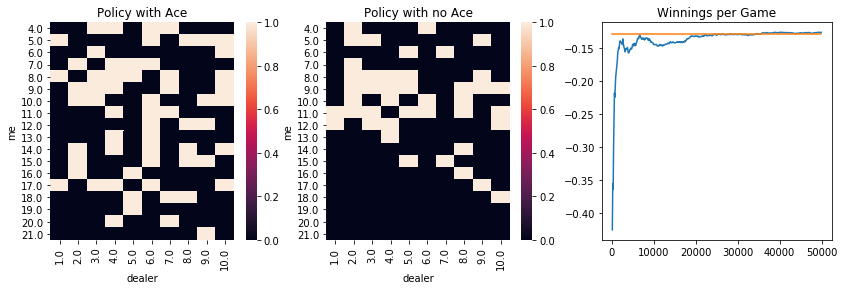

In [7]:
# With exploring starts, greedy policy, random initial policy, and 0 initial values
wlog_mc_es_g_ri_0v = simulate_mc(games=50000, eps=0, initial_q=0, rand=True)

Average winnings of -0.16032


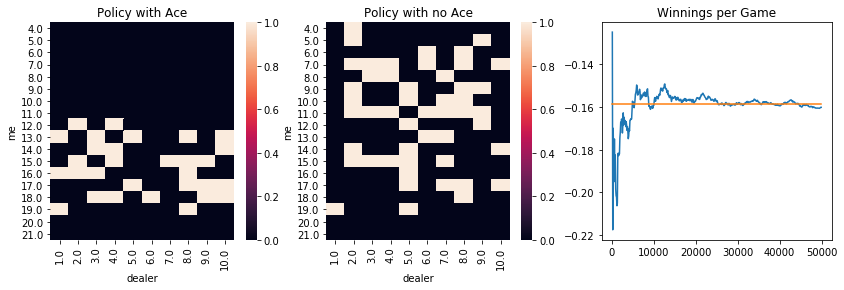

In [8]:
# With exploring starts, greedy policy, arbitrary initial policy, and 0 initial values
wlog_mc_es_g_0i_0v = simulate_mc(games=50000, eps=0, initial_q=0, initial_p=0, rand=False)

Average winnings of -0.15083


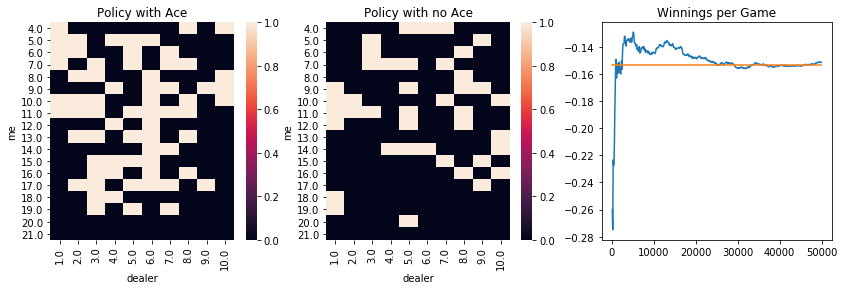

In [9]:
# With exploring starts, greedy policy, random initial policy, and optimistic initial values
wlog_mc_es_g_ri_ov = simulate_mc(games=50000, eps=0, initial_q=2, rand=True)

Average winnings of -0.11258


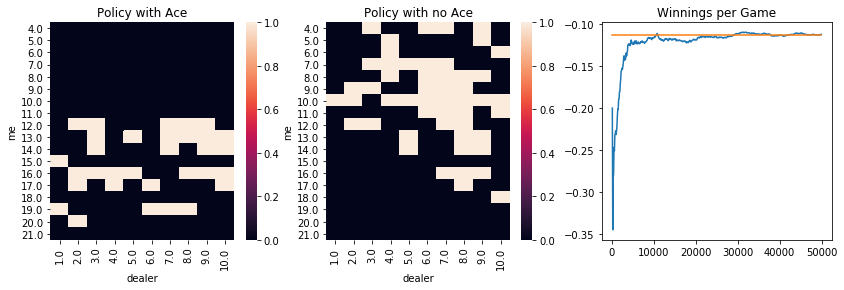

In [10]:
# With exploring starts, greedy policy, arbitrary initial policy, and optimistic initial values
wlog_mc_es_g_0i_ov = simulate_mc(games=50000, eps=0, initial_q=2, initial_p=0, rand=False)

Average winnings of -0.076725


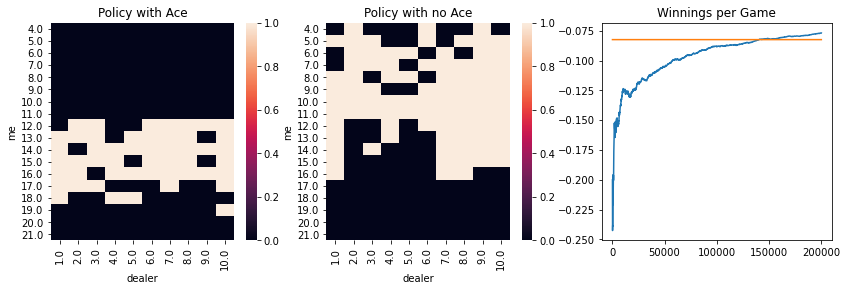

In [7]:
# With exploring starts, epsilon .05 greedy policy, arbitrary initial policy, and optimistic initial values
wlog_mc_es_e05_0i_ov = simulate_mc(games=200000, eps=0.05, initial_q=2, initial_p=0, rand=False)

Average winnings of -0.082315


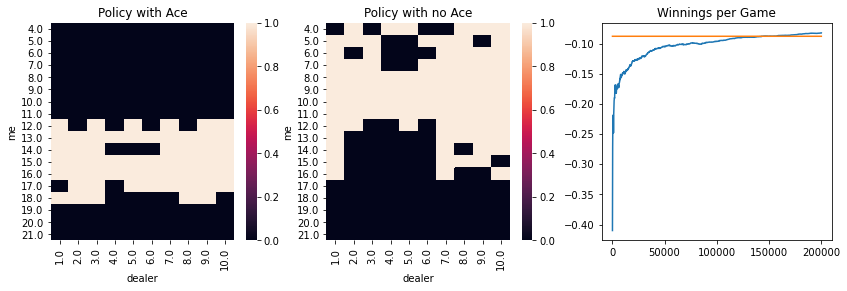

In [8]:
# With exploring starts, epsilon .10 greedy policy, arbitrary initial policy, and optimistic initial values
wlog_mc_es_e10_0i_ov = simulate_mc(games=200000, eps=0.1, initial_q=2, initial_p=0, rand=False)

Average winnings of -0.108815


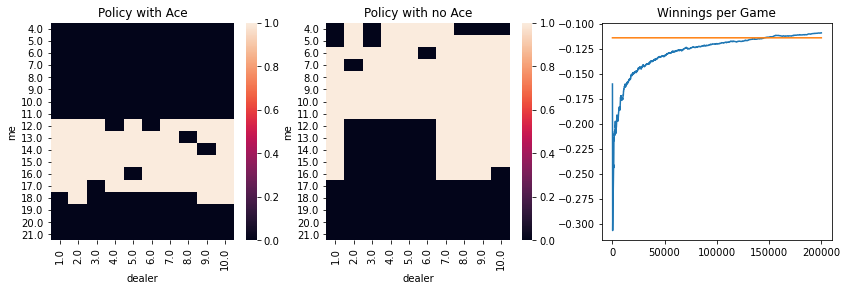

In [9]:
# With exploring starts, epsilon .20 greedy policy, arbitrary initial policy, and optimistic initial values
wlog_mc_es_e20_0i_ov = simulate_mc(games=200000, eps=0.2, initial_q=2, initial_p=0, rand=False)

## Monte Carlo with Ordinary Importance Sampling

Try an off-policy Monte Carlo method that uses a random off-policy and ordinary importance sampling with the following different configurations:
- With exploring starts, greedy policy, random initial target policy, and 0 initial values
- With exploring starts, greedy policy, arbitrary initial target policy, and 0 initial values

In [6]:
# function to simulate ordinary importance sampling
def simulate_mc_ois(games, eps, initial_q=None, initial_p=None, rand=True, initial_pb=0.5):
    winnings = 0
    winning_log = []
    q = initialize_q(initial_q)
    p = initialize_policy(initial_p, rand)
    pb = initialize_policy(initial_pb, False)

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
#                 winnings += reward
                break
            action = choose_prob_action(observation, pb, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)
        imp_ratio = 1
        for i in range(len(action_log)):
            ri = len(action_log)-i-1
            q = mc_ois_update_values(obs_log[ri], action_log[ri], reward, q, imp_ratio)
            p = mc_update_policy(obs_log[ri], q, p)
            p_action = p.loc[(p['me']==obs_log[ri][0]) & (p['dealer']==obs_log[ri][1]) & (p['ace']==obs_log[ri][2])]['action'].values[0]
            pb_prob = pb.loc[(pb['me']==obs_log[ri][0]) & (pb['dealer']==obs_log[ri][1]) & (pb['ace']==obs_log[ri][2])]['action'].values[0]            
            if p_action != action_log[ri]:
                break
            imp_ratio = imp_ratio * 1.0/pb_prob
            
        # run on target policy
        observation = env.reset()
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_prob_action(observation, p, eps)
            observation, reward, done, info = env.step(action)  

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)
            
    print ('Average winnings of', winnings/games)  
    visualize_policy_and_winnings(p, winning_log)
    return winning_log

Average winnings of -0.20459


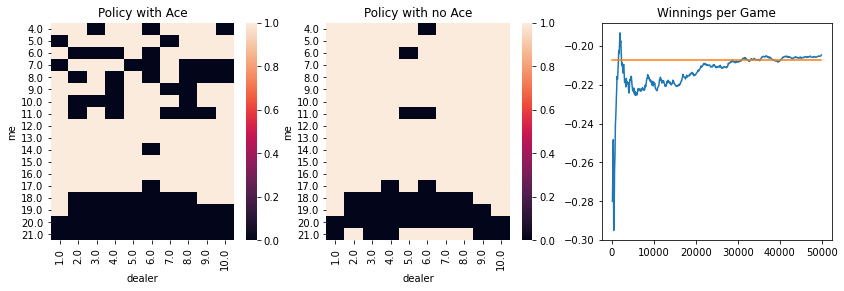

In [7]:
# With exploring starts, greedy policy, random initial policy, and 0 initial values
wlog_mc_ois_es_g_ri_0v = simulate_mc_ois(games=50000, eps=0, initial_q=0, rand=True)

Average winnings of -0.15144


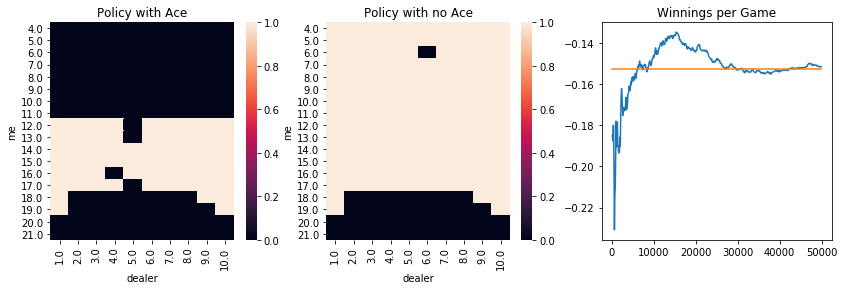

In [24]:
# With exploring starts, greedy policy, arbitrary initial policy, and 0 initial values
wlog_mc_ois_es_g_0i_0v = simulate_mc_ois(games=50000, eps=0, initial_q=0, initial_p=0, rand=False)

## Monte Carlo with Weighted Importance Sampling

Using the best configuration from ordinary importance sampling, compare how weighted importance sampling improves convergence

In [8]:
# function to simulate weighted importance sampling
def simulate_mc_wis(games, eps, initial_q=None, initial_p=None, rand=True, initial_pb=0.5):
    winnings = 0
    winning_log = []
    q = initialize_q(initial_q)
    p = initialize_policy(initial_p, rand)
    pb = initialize_policy(initial_pb, False)

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
#                 winnings += reward
                break
            action = choose_prob_action(observation, pb, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)
        imp_ratio = 1
        for i in range(len(action_log)):
            ri = len(action_log)-i-1
            q = mc_wis_update_values(obs_log[ri], action_log[ri], reward, q, imp_ratio)
            p = mc_update_policy(obs_log[ri], q, p)
            p_action = p.loc[(p['me']==obs_log[ri][0]) & (p['dealer']==obs_log[ri][1]) & (p['ace']==obs_log[ri][2])]['action'].values[0]
            pb_prob = pb.loc[(pb['me']==obs_log[ri][0]) & (pb['dealer']==obs_log[ri][1]) & (pb['ace']==obs_log[ri][2])]['action'].values[0]            
            if p_action != action_log[ri]:
                break
            imp_ratio = imp_ratio * 1.0/pb_prob    
            
            # run on target policy
            observation = env.reset()
            done = 0
            for i in range(20):
                if done:
                    winnings += reward
                    break
                action = choose_prob_action(observation, p, eps)
                observation, reward, done, info = env.step(action)  


        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)
            
    print ('Average winnings of', winnings/games)  
    visualize_policy_and_winnings(p, winning_log)
    return winning_log

Average winnings of -0.06962


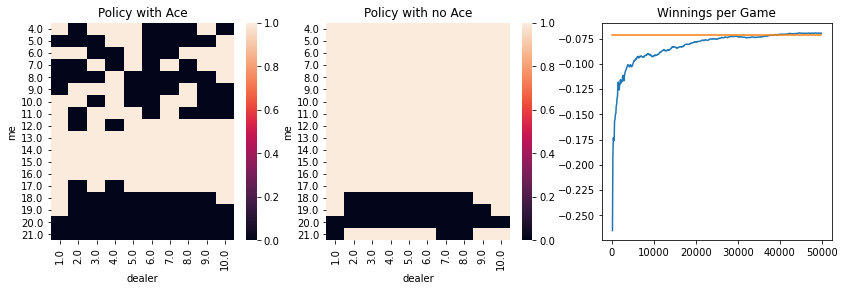

In [9]:
# With exploring starts, greedy policy, random initial policy, and 0 initial values
wlog_mc_wis_es_g_ri_0v = simulate_mc_wis(games=50000, eps=0, initial_q=0, initial_p=0, rand=True)

Average winnings of -0.04302


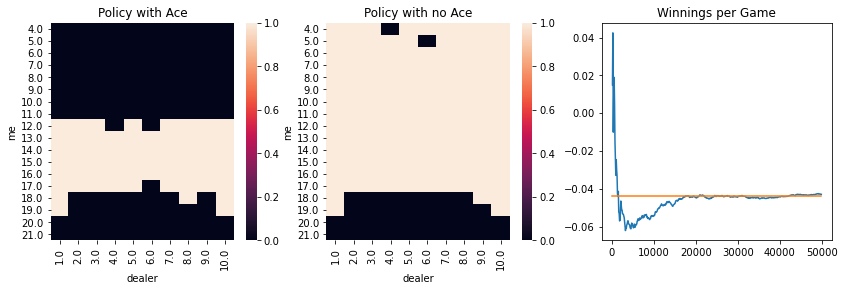

In [10]:
# With exploring starts, greedy policy, arbitrary initial policy, and 0 initial values
wlog_mc_wis_es_g_0i_0v = simulate_mc_wis(games=50000, eps=0, initial_q=0, initial_p=0, rand=False)

## Q-Learning, TD(0)

Assess how a differnt on-policy method, q-learning compares to monte carlo using the best configuation from on-policy monte carlo methods with these different alpha values
- .05
- .1
- .2

In [30]:
# function to simulate q learning algorithm
def simulate_q_learning(games, eps, alpha, initial_q=None, initial_p=None, rand=True):
    # run through several games and record winnings

    winnings = 0
    winning_log = []
    q = initialize_q(initial_q)
    p = initialize_policy(initial_p, rand)

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_action(observation, p, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)
            q = q_update_values(obs_log[i], action_log[i], reward, q, p, alpha)
            p = q_update_policy(obs_log[i], q, p)

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)

    print ('Average winnings of', winnings/games)            
    visualize_policy_and_winnings(p, winning_log)

Average winnings of -0.87934


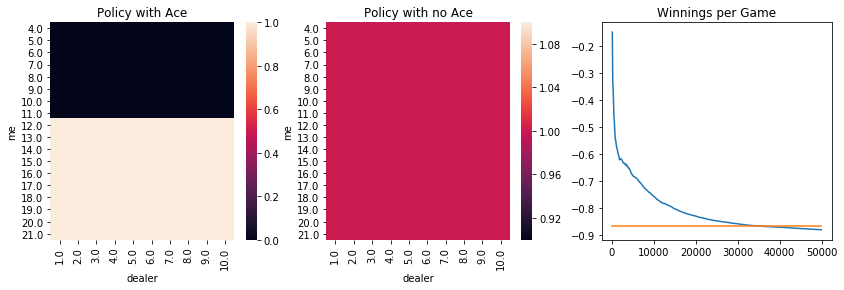

In [31]:
# With exploring starts, epsilon .10 greedy policy, arbitrary initial policy, and optimistic initial values, alpha of 0.05
wlog_q_es_e10_a05_0i_ov = simulate_q_learning(games=50000, eps=0.1, alpha=0.05, initial_q=2, initial_p=0, rand=False)


In [32]:
# With exploring starts, epsilon .10 greedy policy, arbitrary initial policy, and optimistic initial values, alpha of 0.1
wlog_q_es_e10_a10_0i_ov = simulate_q_learning(games=50000, eps=0.1, alpha=0.1, initial_q=2, initial_p=0, rand=False)


KeyboardInterrupt: 

In [ ]:
# With exploring starts, epsilon .10 greedy policy, arbitrary initial policy, and optimistic initial values, alpha of 0.2
wlog_q_es_e10_a20_0i_ov = simulate_q_learning(games=50000, eps=0.1, alpha=0.2, initial_q=2, initial_p=0, rand=False)


## Compare to supposed optimal policy

Use a pre-defined supposed optimal policy to see how all these algorithms compare

In [11]:
def define_optimal_policy(p):
    new_p = p.copy()
    new_p['action'] = 0
    
    new_p.loc[(p['ace']==0) & (new_p['me']<=11), 'action'] = 1
    new_p.loc[(p['ace']==0) & (new_p['me']>=12) & (new_p['me']<=16) & (new_p['dealer']>=7), 'action'] = 1
    
    new_p.loc[(p['ace']==1) & (new_p['me']<=17), 'action'] = 1
    new_p.loc[(p['ace']==1) & (new_p['me']==18) & (new_p['dealer']>=9), 'action'] = 1
    
    return new_p

In [12]:
def simulate_optimal(games, eps):
    # run through several games and record winnings

    winnings = 0
    winning_log = []
    p = initialize_policy()
    p = define_optimal_policy(p)

    for ep in range(games):
        observation = env.reset()
        obs_log = []
        action_log = []
        obs_log.append(observation)
        done = 0
        for i in range(20):
            if done:
                winnings += reward
                break
            action = choose_action(observation, p, eps)
            action_log.append(action)
            observation, reward, done, info = env.step(action)  
            obs_log.append(observation)

        if ep>0 and ep%100 == 0:
            winning_log.append(winnings/ep)

    print ('Average winnings of', winnings/games)  
    visualize_policy_and_winnings(p, winning_log)
    return winning_log

Average winnings of -0.02345


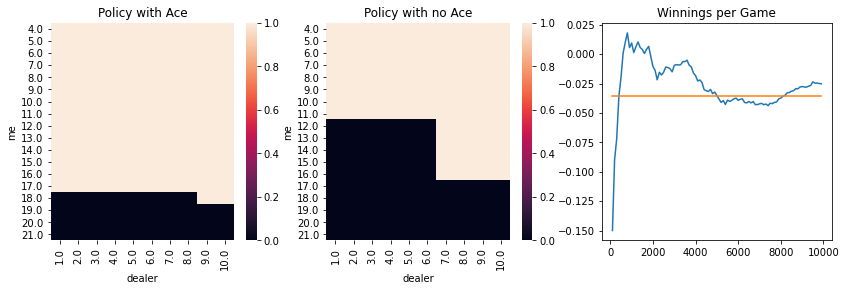

In [19]:
o_0 = simulate_optimal(10000, 0)

Average winnings of -0.0414


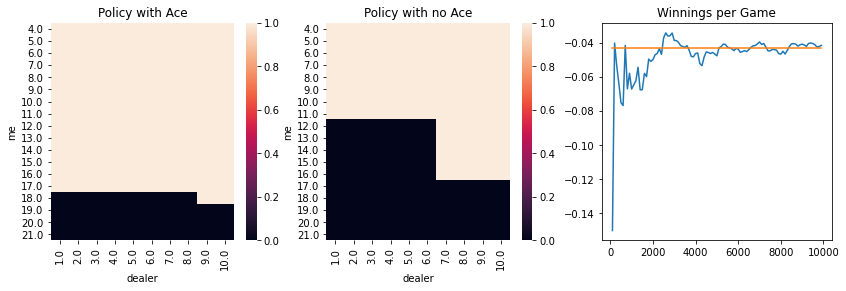

In [21]:
o_05 = simulate_optimal(10000, 0.05)

Average winnings of -0.06535


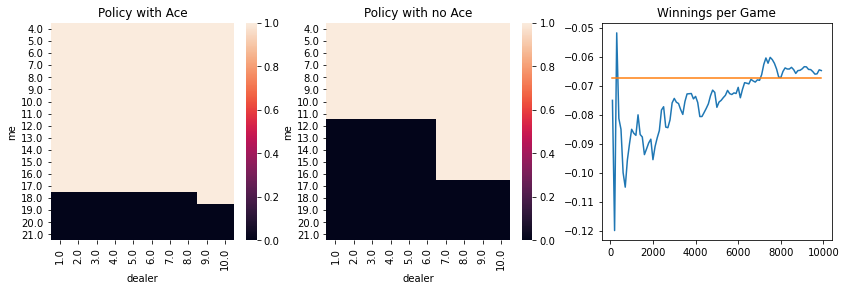

In [22]:
o_10 = simulate_optimal(10000, 0.1)

Average winnings of -0.0935


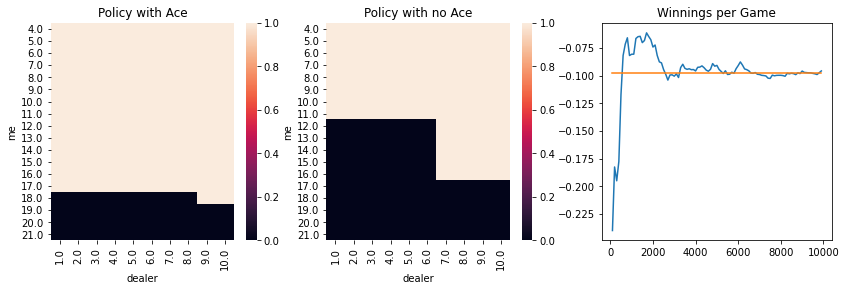

In [23]:
o_20 = simulate_optimal(10000, 0.2)